In [55]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from __future__ import unicode_literals

import seaborn as sns

%matplotlib inline

In [56]:
from pylab import rcParams
rcParams['figure.figsize'] = (18,18)

There are several good resources for map drawing, for instace:

The one from [sensitivecities](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.Vr2I43UrKkA "quite dense in info!").

Below, we draw a basic map of London wards and the river Thames. The shapefiles used are the 2014 files from [here](http://data.london.gov.uk/dataset/statistical-gis-boundary-files-london).

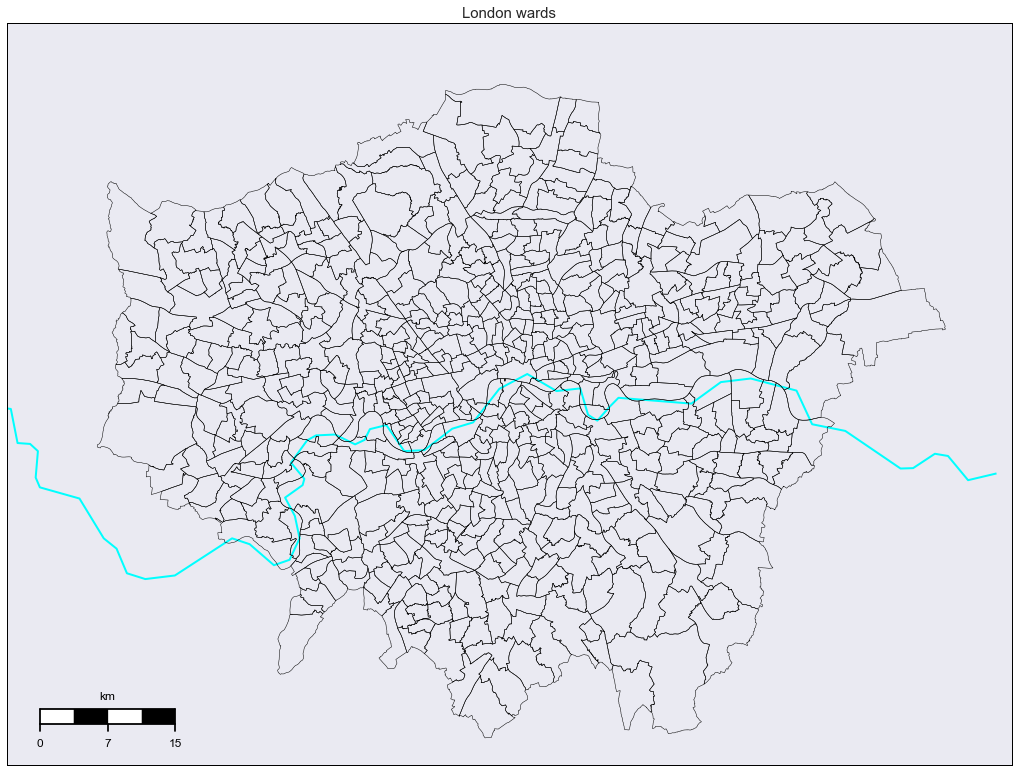

In [57]:
myMap = Basemap(projection='merc',resolution='h',area_thresh=0.1,
                llcrnrlon=-.6,llcrnrlat=51.27,urcrnrlon=.4,urcrnrlat=51.73)

myMap.drawmapboundary()

myMap.drawrivers(color='aqua',linewidth=2.)
myMap.drawmapscale(lon=-.5,lat=51.3,lon0=-0.13,lat0=51.51,length=15,barstyle='fancy',fontsize=12)

# ogr2ogr -t_srs EPSG:4326 test.shp London_Ward_CityMerged.shp

myMap.readshapefile('data/London-wards-2014_ESRI/London_Ward_ESPG4326','london')

plt.title('London wards',size=15)

plt.show()

The shapefile contains a lot of information, accessible as below. In the above, the second parameter, `'london'`, creates new attributes of `myMap` called `myMap.lodon` (containing all the points) and `myMap.london_info` with description of the shapes.

In [58]:
print myMap.london_info[:4]

[{'GSS_CODE': 'E05000405', 'NAME': 'Chessington South', 'RINGNUM': 1, 'LB_GSS_CD': 'E09000021', 'HECTARES': 755.173, 'SHAPENUM': 1, 'BOROUGH': 'Kingston upon Thames', 'POLY_ID': 50840, 'NONLD_AREA': 0.0}, {'GSS_CODE': 'E05000414', 'NAME': 'Tolworth and Hook Rise', 'RINGNUM': 1, 'LB_GSS_CD': 'E09000021', 'HECTARES': 259.464, 'SHAPENUM': 2, 'BOROUGH': 'Kingston upon Thames', 'POLY_ID': 117160, 'NONLD_AREA': 0.0}, {'GSS_CODE': 'E05000401', 'NAME': 'Berrylands', 'RINGNUM': 1, 'LB_GSS_CD': 'E09000021', 'HECTARES': 145.39, 'SHAPENUM': 3, 'BOROUGH': 'Kingston upon Thames', 'POLY_ID': 50449, 'NONLD_AREA': 0.0}, {'GSS_CODE': 'E05000400', 'NAME': 'Alexandra', 'RINGNUM': 1, 'LB_GSS_CD': 'E09000021', 'HECTARES': 268.506, 'SHAPENUM': 4, 'BOROUGH': 'Kingston upon Thames', 'POLY_ID': 50456, 'NONLD_AREA': 0.0}]


The `RINGNUM` key above looks like it may contain the information relating to the public transport zones, however, it does not as shown below:

In [59]:
rings = []

for ward in myMap.london_info:
    rings.append(ward['RINGNUM'])

print set(rings)

set([1])


In [60]:
import pandas as pd

Having downloaded the bus stop data from the [TfL website](https://api-portal.tfl.gov.uk/docs), we can now read in the data.

In [61]:
busStops = pd.read_csv('data/bus-stops.csv')

# virtual stops are only for testing
busStops = busStops[busStops['Virtual_Bus_Stop'] == 0]

busStops.keys()

Index([u'﻿Stop_Code_LBSL', u'Bus_Stop_Code', u'Naptan_Atco', u'Stop_Name',
       u'Location_Easting', u'Location_Northing', u'Heading', u'Stop_Area',
       u'Virtual_Bus_Stop'],
      dtype='object')

The bus stop locations are not in the lonlat units, so below we transform them using `pyproj`.

In [62]:
import pyproj

In [63]:
def proj_transform(df):
    # Transforms British coords into lon and lat
    # Stolen from Alberto Negron 
    # http://altons.github.io/python/2012/12/01/converting-northing-and-easting-to-latitude-and-longitude/
    bng = pyproj.Proj(init='epsg:27700')
    wgs84 = pyproj.Proj(init='epsg:4326')
    lon,lat = pyproj.transform(bng,wgs84,list(df['Location_Easting']), list(df['Location_Northing']))
    
    df['lat'] = lat
    df['lon'] = lon
    return df

In [64]:
busStops = proj_transform(busStops)

To vaguely check how well the transformation did, we plot the London road grid below the bus stops. At first glance they overlap well. However, Thames seems not to be where we would expect it ad we will not plot it any more (it's not relevant to the analysis).

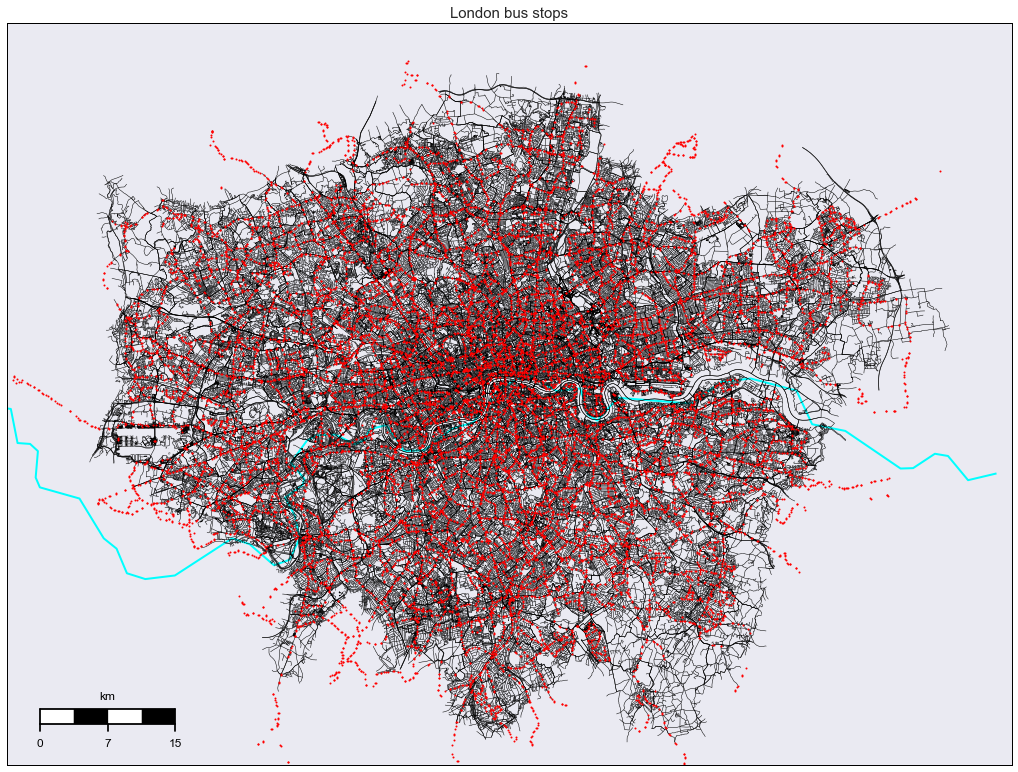

In [65]:
myMap = Basemap(projection='merc',resolution='h',area_thresh=0.1,
                llcrnrlon=-.6,llcrnrlat=51.27,urcrnrlon=.4,urcrnrlat=51.73)

myMap.drawmapboundary()

myMap.drawrivers(color='aqua',linewidth=2.)
myMap.drawmapscale(lon=-.5,lat=51.3,lon0=-0.13,lat0=51.51,length=15,barstyle='fancy',fontsize=12)

# ogr2ogr -t_srs EPSG:4326 test.shp London_Ward_CityMerged.shp

myMap.readshapefile('data/London-wards-2014_ESRI/London_Ward_ESPG4326','london')
myMap.readshapefile('data/roads','roads')

x,y = myMap(list(busStops['lon']),list(busStops['lat']))

myMap.plot(x,y,'ro',markersize=2)

plt.title('London bus stops',size=15)

plt.show()

Zooming on the city centre, we see even better the agreement beween the streets and the bus stops, as well as the presumably inaccurate data about the Thames in the default data set.

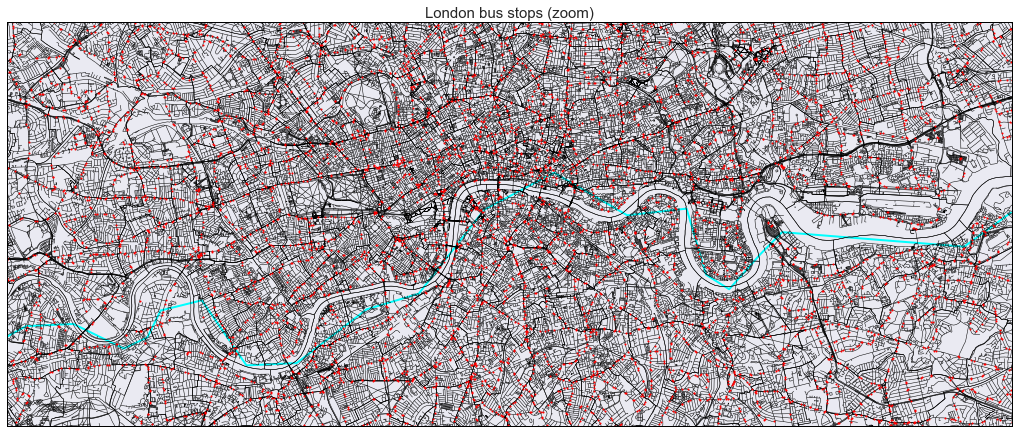

In [67]:
zoomMap = Basemap(projection='merc',resolution='h',area_thresh=0.1,
                llcrnrlon=-.3,llcrnrlat=51.45,urcrnrlon=.1,urcrnrlat=51.55)

zoomMap.drawmapboundary()

zoomMap.drawrivers(color='aqua',linewidth=2.)
#myMap.drawmapscale(lon=-.27,lat=51.53,lon0=-0.13,lat0=51.51,length=1,barstyle='fancy',fontsize=12)

# ogr2ogr -t_srs EPSG:4326 test.shp London_Ward_CityMerged.shp

zoomMap.readshapefile('data/London-wards-2014_ESRI/London_Ward_ESPG4326','london')
zoomMap.readshapefile('data/roads','roads')

x,y = zoomMap(list(busStops['lon']),list(busStops['lat']))

zoomMap.plot(x,y,'o',color=(1.,0.,0.),markersize=2)

plt.title('London bus stops (zoom)',size=15)

plt.show()

Almost all of the code in the following has been appropriated from [sensitivecities](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.Vr6_6HUrKkD) mentioned above.

In [68]:
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon 
from shapely.prepared import prep

In [69]:
wards = pd.DataFrame({'name': [n['NAME'] for n in myMap.london_info],
                      'areaHa': [float(n['HECTARES']) for n in myMap.london_info],
                     'poly': [Polygon(xy) for xy in myMap.london],
                     'borough': [n['BOROUGH'] for n in myMap.london_info],
                     'nonLand': [float(n['NONLD_AREA']) for n in myMap.london_info]})

wardsPoly = prep(MultiPolygon(list(wards['poly'].values)))
busPoints = MultiPoint([Point(myMap(mapX,mapY)) for mapX, mapY in zip(busStops['lon'], busStops['lat'])])

cityStops = filter(wardsPoly.contains,busPoints)

wards['count'] = wards['poly'].map(lambda x: int(len(filter(prep(x).contains, cityStops))))
wards['busStopDensity'] = 100*wards['count']/(wards['areaHa']-wards['nonLand']) #in stops per sq. km

In [70]:
from pysal.esda.mapclassify import Natural_Breaks as nb

In [71]:
breaks = nb(wards['busStopDensity'].values,initial=500,k=10)

In [72]:
wards['jBins'] = breaks.yb

In [73]:
jLabels = ["<= %0.1f/km$^2$(%s wards)" % (b, c) for b, c in zip(breaks.bins, breaks.counts)]

In [74]:
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [77]:
cmap = plt.get_cmap('Blues')

wards['patches'] = wards['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))

The colorbar function below comes from [here](http://beneathdata.com/how-to/visualizing-my-location-history/), where a somewhat similar thing is being done like with the sensitivecities.

In [78]:
def custom_colorbar(cmap, ncolors, labels, **kwargs):    
    """Create a custom, discretized colorbar with correctly formatted/aligned labels.
    
    cmap: the matplotlib colormap object you plan on using for your graph
    ncolors: (int) the number of discrete colors available
    labels: the list of labels for the colorbar. Should be the same length as ncolors.
    """
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
        
    norm = BoundaryNorm(range(0, ncolors), cmap.N)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors+1)+0.5)
    colorbar.set_ticklabels(range(0, ncolors))
    colorbar.set_ticklabels(labels)
    return colorbar


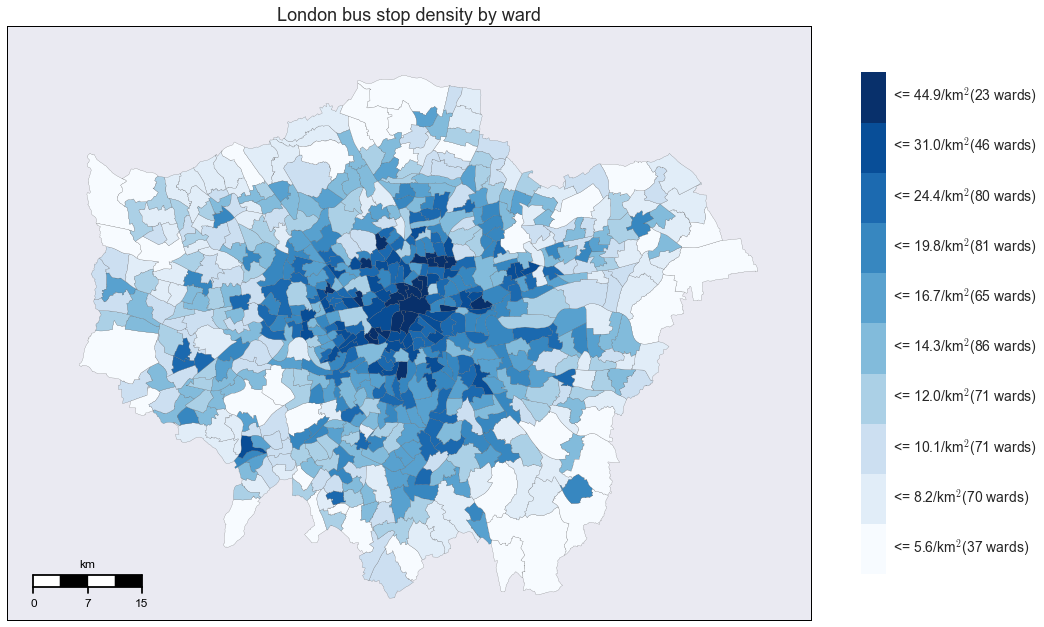

In [83]:
pc = PatchCollection(wards['patches'],match_original=True)

pc.set_facecolor(cmap(wards['jBins'].values/9.))
#pc.set_facecolor(cmap(Normalize(wards['jBins'].values)))

fig = plt.figure()

ax = fig.add_subplot(111)

myMap = Basemap(projection='merc',resolution='h',area_thresh=0.1,
                llcrnrlon=-.6,llcrnrlat=51.27,urcrnrlon=.4,urcrnrlat=51.73)

myMap.drawmapboundary()

ax.add_collection(pc)

cbar = custom_colorbar(cmap, ncolors=len(jLabels)+1, labels=jLabels, shrink=0.5)
cbar.ax.tick_params(labelsize=14)

myMap.drawmapscale(lon=-.5,lat=51.3,lon0=-0.13,lat0=51.51,length=15,barstyle='fancy',fontsize=12)

plt.title('London bus stop density by ward',size=18)

#cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
#cb.ax.tick_params(labelsize=6)

plt.show()

Excellent! The next two steps are including other, non-bus stops into the map (tube, trams, ...). The second - and, potentially, more important issue is to correlate the map with the density of inhabitants. For instance, both in the southeast and soutwest of London there are wards with a higher stop density than their surroundings. The density of hte people is the first thing that comes to mind to explain these. Alternatively, some of them may disappear when tube stops are also included - presumably with tube present, we wouldn't need that many bus stops.

#### Side notes

* study the Natural_Breaks function - currently the breaks are not qudistant. This is essentially the same problem as the ds9 scaling. Think about the relative importance of pretty plots vs. the viewer's expectation (e.g., that a break halfway through the scale might have half the density).